# Compare local thrombolysis decisions with benchmark decisions

## Plain English summary

This notebook compares local thrombolysis decisions with those expected at the majority of a 30-hospital set of benchmark hospitals. 

The XGBoost model uses 8 features: 

* Arrival-to-scan time
* Infarction
* Stroke severity
* Precise onset time
* Prior disability level
* Stroke team
* Use of AF anticoagulants
* Onset-to-arrival time

Benchmark decisions are decisions made at the majority of the top 30 hospitals as judged by their expected thrombolysis use in a standard 10k cohort of patients (a set of 10k patients that is passed through the models of decision-making at each hospital). 

If benchmark decisions were used at all hopsitals, then thrombolysis use would increase 22%. Thrombolysis use at the bottom 30 thrombolsying hospitals would increase 63%.

## Model and data
(Use the XGBoost models that were trained in notebook 02). 

XGBoost models were trained on stratified k-fold cross-validation data. The 8 features in the model are:
* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)

And one target feature:
* Thrombolysis: Recieve thrombolysis (1 = Yes, 0 = No)

The 8 features included in the model (to predict whether a patient will recieve thrombolysis) were chosen sequentially as having the single best improvement in model performance (using the ROC AUC). The stroke team feature is included as a one-hot encoded feature.

## Aims

* Predict thrombolysis use of 10k cohort of patients at all 132 hospitals.
* Get predicted thrombolysis decisions for all patients at the 30 benchmark hospitals.
* Check similarity between local decisions and benchmark decisions.
* Estimate thrombolysis use at each hospital if benchmark decisions made.
* Save comparison of local and benchmark decisions.

## Observations

* 82.8% decisions are identical between local and benchmark decisions.
* Thrombolysis use would be increased 22.6% if benchmark decisions were made at all hospitals.
* The ratio of benchmark:local thrombolysis use was 0.7 to 2.2.

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.lines import Line2D

from xgboost import XGBClassifier

import json
import pickle

## Set filenames

In [2]:
# Set model type (used in file save, e.g. xgb_combined_calibrated_oversampled)
number_of_features_to_use = 8
model_text = f'xgb_{number_of_features_to_use}_features'
notebook = '05'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)   

## Read in JSON file
Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data on predicted 10k cohort thrombolysis use at each hospital

In [5]:
thrombolysis_by_hosp = pd.read_csv(
    './output/04_10k_thrombolysis_rate_by_hosp_key_features.csv', 
    index_col='stroke_team')
thrombolysis_by_hosp.sort_values(
    'Thrombolysis rate', ascending=False, inplace=True)

In [6]:
thrombolysis_by_hosp.head()

,Thrombolysis rate
stroke_team,
VKKDD9172T,0.4610
GKONI0110I,0.4356
CNBGF2713O,0.4207
HPWIF9956L,0.4191
MHMYL4920B,0.3981


In [7]:
top_30_hospitals = list(thrombolysis_by_hosp.head(30).index)
bottom_30_hospitals = list(thrombolysis_by_hosp.tail(30).index)

## Load data
Data has previously been split into 5 stratified k-fold splits.

Read in data and keep the number of key features as specified (for this notebook, that's 8 key features)

In [8]:
data_loc = '../data/kfold_5fold/'

In [9]:
train_data_kfold, test_data_kfold = [], []

# Load features (and add S2Thrombolysis)
number_of_features_to_use = 8
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
key_features.append('S2Thrombolysis')

for i in range(5):
    train = pd.read_csv(data_loc + 'train_{0}.csv'.format(i))
    train = train[key_features]
    train.rename(columns=dict_feature_name, inplace=True)
    train_data_kfold.append(train)
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=dict_feature_name, inplace=True)
    test_data_kfold.append(test)

## Read in XGBoost model and results
In notebook 02_xgb_combined_fit_accuracy_key_features.ipynb we fit an XGBoost model for each k-fold training/test split, and got feature importance values (a value per feature, per model from each k-fold split).

Load the models.

In [10]:
# Set up lists for k-fold fits
model_kfold = []
feature_importance_kfold = []
y_pred_kfold = []
y_prob_kfold = []
X_train_kfold = []
X_test_kfold = []
y_train_kfold = []
y_test_kfold = []

# For each k-fold split
for k in range(5):
    # Get X and y
    X_train = train_data_kfold[k].drop('Thrombolysis', axis=1)
    X_test = test_data_kfold[k].drop('Thrombolysis', axis=1)
    y_train = train_data_kfold[k]['Thrombolysis']
    y_test = test_data_kfold[k]['Thrombolysis']

    # One hot encode hospitals
    X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
    X_train = pd.concat([X_train, X_train_hosp], axis=1)
    X_train.drop('Stroke team', axis=1, inplace=True)
    X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
    X_test = pd.concat([X_test, X_test_hosp], axis=1)
    X_test.drop('Stroke team', axis=1, inplace=True)
    
    # Store processed X and y
    X_train_kfold.append(X_train)
    X_test_kfold.append(X_test)
    y_train_kfold.append(y_train)
    y_test_kfold.append(y_test)

    # Load models
    filename = f'./saved_models/02_{model_text}_{k}.p'
    with open(filename, 'rb') as filehandler:
        model = pickle.load(filehandler)
        model_kfold.append(model)        

    # Get and store feature importance values
    feature_names_ohe = list(X_train_kfold[0])
    feature_importances = model.feature_importances_
    df = pd.DataFrame(index=feature_names_ohe)
    df['importance'] = feature_importances
    df['rank'] = (df['importance'].rank(ascending=False).values)
    feature_importance_kfold.append(df)

    # Get and store predicted class and probability
    y_pred = model.predict(X_test)
    y_pred_kfold.append(y_pred)
    y_prob = model.predict_proba(X_test)[:, 1]
    y_prob_kfold.append(y_prob)

    # Measure accuracy for this k-fold model
    accuracy = np.mean(y_pred == y_test)
    print(f'Accuracy k-fold {k+1}: {accuracy:0.3f}')

Accuracy k-fold 1: 0.846
Accuracy k-fold 2: 0.853
Accuracy k-fold 3: 0.845
Accuracy k-fold 4: 0.849
Accuracy k-fold 5: 0.844


## Get predicted decision for all patients at each hopsital

Combine test results for kfold data in a dataframe (all individuals are predicted from a test set).

In [11]:
thrombolysis_predictions_at_own_unit_kfold = []

for k in range(5):
    df = pd.DataFrame()
    df['Home hospital'] = test_data_kfold[k]['Stroke team']
    df['Observed IVT'] = y_test_kfold[k]
    df['Predicted IVT'] = y_pred_kfold[k]
    df['Predicted probability IVT'] = y_prob_kfold[k]
    thrombolysis_predictions_at_own_unit_kfold.append(df)
    
df_patient_thrombolysis_decisions = pd.concat(
    thrombolysis_predictions_at_own_unit_kfold, axis=0)

## Get predictions at 30 benchmark hospitals

In [12]:
# Initialise list
top_30_predictions_kfold = []

# Loop through k folds
for k in range(5):
    
    # Initialise list to store treatment predictions for all patients going to
    #   each benchmark hospital
    predictions_kfold = []
    
    # Get predicted probabilities and class
    model = model_kfold[k]
    
    # For each benchmark hospital
    for hospital in top_30_hospitals:

        # Get X and y for this kfold split
        X_train = train_data_kfold[k].drop('Thrombolysis', axis=1)
        X_test = test_data_kfold[k].drop('Thrombolysis', axis=1)
        y_train = train_data_kfold[k]['Thrombolysis']
        y_test = test_data_kfold[k]['Thrombolysis']

        # One hot encode hospitals
        X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
        X_train = pd.concat([X_train, X_train_hosp], axis=1)
        X_train.drop('Stroke team', axis=1, inplace=True)
        X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
        X_test = pd.concat([X_test, X_test_hosp], axis=1)
        X_test.drop('Stroke team', axis=1, inplace=True) 

        # Get test data without thrombolysis or stroke team
        X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)

        # Copy hospital dataframe, set all hospital ID to zero, then set just 
        #   the benchmark hospital ID to 1
        X_test_adjusted_hospital = X_test_hosp.copy()
        X_test_adjusted_hospital.loc[:,:] = 0
        team = "team_" + hospital
        X_test_adjusted_hospital[team] = 1

        # Add adjusted hospital data back to the rest of the test data
        X_test_adjusted = pd.concat(
            [X_test_no_hosp, X_test_adjusted_hospital], axis=1)

        # Model predict treatment for all patients attending benchmark hosptial
        y_probs = model.predict_proba(X_test_adjusted)[:,1]
        y_pred = y_probs > 0.5
        predictions_kfold.append(y_pred * 1)
    
    # Store predictions (for each kfold, for each 30 benchmark hosptial, for 
    #   each patient)
    top_30_predictions_kfold.append(predictions_kfold)

The list top_30_predictions_kfold has [a][b][c] where:
* [a] = k fold (there are 5)
* [b] = benchmark hospital (there are 30)
* [c] = individual (there are 17k)

Create a DataFrame (*df_benchmark_decisions*) which stores for each patient, which hospital they attended (*Home hospital*), and whether they would recieve thrombolysis if the 30 benchmark hosptials had a majority vote (*Benchmark majority vote*).

In [13]:
benchmark_decisions_kfold = []

for k in range(5):
    df = pd.DataFrame()
    df['Home hospital'] = test_data_kfold[k]['Stroke team']
    predictions = top_30_predictions_kfold[k][:][:]    
    benchmark_yes_count = np.array(predictions).sum(axis=0)
    df['Benchmark majority vote'] = (benchmark_yes_count >= 15) * 1.0
    benchmark_decisions_kfold.append(df)
    
df_benchmark_decisions = pd.concat(benchmark_decisions_kfold,  axis=0)

In [14]:
df_benchmark_decisions.head()

,Home hospital,Benchmark majority vote
0,TXHRP7672C,0.0
1,SQGXB9559U,0.0
2,LFPMM4706C,1.0
3,MHMYL4920B,0.0
4,EQZZZ5658G,1.0


Add this to the DataFrame

In [15]:
df_patient_thrombolysis_decisions['Benchmark majority vote'] = \
    df_benchmark_decisions['Benchmark majority vote']

In [16]:
df_patient_thrombolysis_decisions.head()

,Home hospital,Observed IVT,Predicted IVT,Predicted probability IVT,Benchmark majority vote
0,TXHRP7672C,1,1,0.880155,0.0
1,SQGXB9559U,1,1,0.627783,0.0
2,LFPMM4706C,0,0,0.042199,1.0
3,MHMYL4920B,0,0,0.000084,0.0
4,EQZZZ5658G,1,1,0.916311,1.0


## Check similarity of own decisions vs benchmark decisions.

In [17]:
same_decision = (
    df_patient_thrombolysis_decisions['Observed IVT'] == 
    df_patient_thrombolysis_decisions['Benchmark majority vote'])

In [18]:
print(f'Proportion of patients with same IVT decision at their home hospital '
      f'and if use the benchmark hospitals majority vote '
      f'{same_decision.mean():0.3f}')

Proportion of patients with same IVT decision at their home hospital and if use the benchmark hospitals majority vote 0.612


## Count number thrombolysed at each hospital compared with benchmark
Compare the number of patients that receive IVT at each hospital depending of whether use the 1) observed IVT data 2) model predicted result for home hospital 3) majority vote from benchmark hospitals.

In [19]:
thrombolysis_counts = (
    df_patient_thrombolysis_decisions.groupby('Home hospital').agg('sum').drop(
    'Predicted probability IVT', axis=1))

In [20]:
thrombolysis_counts.head()

,Observed IVT,Predicted IVT,Benchmark majority vote
Home hospital,,,
AGNOF1041H,307,307,343.0
AKCGO9726K,528,512,505.0
AOBTM3098N,128,127,200.0
APXEE8191H,130,116,194.0
ATDID5461S,75,74,114.0


### Estimate change in thrombolysis rate if benchmark decisions used at all hospitals

In [21]:
change = (thrombolysis_counts['Benchmark majority vote'].sum() / 
          thrombolysis_counts['Observed IVT'].sum())

percent_change = (change -1) * 100

print (f'Percent change in thrombolysis with benchmark vote: '\
       f'{percent_change:.1f}%')

Percent change in thrombolysis with benchmark vote: 22.3%


### Estimate change in thrombolysis rate at bottom 30 thrombolysing hospitals if benchmark decisions used

In [28]:
numerator = (
thrombolysis_counts.loc[bottom_30_hospitals]['Benchmark majority vote'].sum())

denum = thrombolysis_counts.loc[bottom_30_hospitals]['Observed IVT'].sum()

change = (numerator / denum)
percent_change = (change -1) * 100

print (f'Percent increase in thrombolysis at bottom 30 hospitals with '\
       f'benchmark decisions: {percent_change:.1f}%')

Percent increase in thrombolysis at bottom 30 hospitals with benchmark decisions: 67.6%


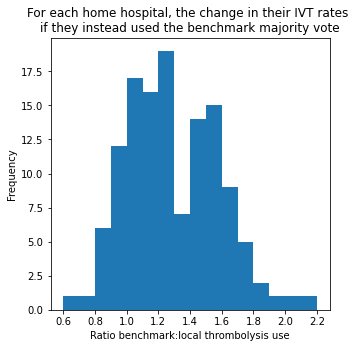

In [23]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ratio = thrombolysis_counts['Benchmark majority vote'] / thrombolysis_counts['Observed IVT']
ax.hist(ratio, bins = np.arange(0.6, 2.3, 0.1))
ax.set_xlabel('Ratio benchmark:local thrombolysis use')
ax.set_ylabel('Frequency')
ax.set_title('For each home hospital, the change in their IVT rates \nif they '
             'instead used the benchmark majority vote')

plt.show()

## Add patient counts at units, and calculate thrombolysis rate

In [24]:
unit_count = df_patient_thrombolysis_decisions.groupby(
    'Home hospital').count()['Observed IVT']

In [25]:
thrombolysis_counts['Patients'] = unit_count
thrombolysis_counts['Observed IVT rate'] = (
    thrombolysis_counts['Observed IVT'] / thrombolysis_counts['Patients'])
thrombolysis_counts['Benchmark IVT rate'] = (
    thrombolysis_counts['Benchmark majority vote'] / thrombolysis_counts['Patients'])

Add benchmark label

In [26]:
thrombolysis_counts['Benchmark hospital'] = False
thrombolysis_counts['Benchmark hospital'].loc[top_30_hopsitals] = True

NameError: name 'top_30_hopsitals' is not defined

In [ ]:
thrombolysis_counts.head()

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()

# Plot non-benchmark hospitals in blue
mask = thrombolysis_counts['Benchmark hospital'] == False
non_bench = thrombolysis_counts[mask]

for i, val in non_bench.iterrows():
    start = [non_bench['Observed IVT rate'] * 100,
             non_bench['Observed IVT rate'] * 100]
    end = [non_bench['Observed IVT rate'] * 100,
             non_bench['Benchmark IVT rate'] * 100]
    ax.plot(start, end, c='b', lw=1, zorder=1)
    ax.scatter(start[0], start[1], marker='o', facecolors='b', edgecolors='b', 
               s=20, zorder=2, alpha=0.6)
    ax.scatter(end[0], end[1], marker='o', facecolors='w', edgecolors='b',
               s=20, zorder=2, alpha=0.6)

# Plot benchmark hospitals in red
mask = thrombolysis_counts['Benchmark hospital'] == True
bench = thrombolysis_counts[mask]

for i, val in bench.iterrows():
    start = [bench['Observed IVT rate'] * 100,
             bench['Observed IVT rate'] * 100]
    end = [bench['Observed IVT rate'] * 100,
             bench['Benchmark IVT rate'] * 100]
    ax.plot(start, end, c='r', lw=1, zorder=1)
    ax.scatter(start[0], start[1], marker='o', facecolors='r', edgecolors='r', 
               s=20, zorder=2, alpha=0.6)
    ax.scatter(end[0], end[1], marker='o', facecolors='w', edgecolors='r',
               s=20, zorder=2, alpha=0.6)

# Add mods 
ax.set_xlabel('Observed thrombolysis rate (%)')
ax.set_ylabel('Predicted benchmark thrombolysis rate (%)')
ax.set_xlim(0, 55)
ax.set_ylim(0, 55)
ax.grid()

custom_lines = [Line2D([0], [0], color='r', alpha=0.6, lw=2),
                Line2D([0], [0], color='b', alpha = 0.6,lw=2)]

plt.legend(custom_lines, ['Benchmark hospital', 'Non-benchmark hospital'],
          loc='lower right')

plt.tight_layout()
plt.savefig(f'output/{notebook}_benchmark_thrombolysis_key_features.jpg', dpi=300)

plt.show()

## Save comparisons of decisions

In [ ]:
thrombolysis_predictions_at_own_unit.to_csv(
    f'./predictions/{notebook}_benchmark_decisions_combined_xgb_key_features.csv',
    index=False)

In [ ]:
test_collated = pd.concat(test_data, axis=0)
test_collated.to_csv(f'./predictions/{notebook}_test_features_collated_key_features.csv',
                     index=False)

## Observations

* 82.9% decisions are identical between local and benchmark decisions.
* Thrombolysis use would be increased 22.6% if benchmark decisions were made at all hospitals.
* The ration of benchmark:local thrombolysis use was 0.7 to 2.2.